In [1]:
!pip install torchdiffeq

In [2]:
import os
import argparse
import time
import psutil
import scipy.io
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from torchdiffeq import odeint

gpu = 0
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

## Loading Data

In [3]:
train_mat = scipy.io.loadmat('../input/npdetest/S_train_20.mat')
params_train_mat = scipy.io.loadmat('../input/npdetest/params_train_20.mat')
test_mat = scipy.io.loadmat('../input/npdetest/S_test_20_extended.mat')
params_test_mat = scipy.io.loadmat('../input/npdetest/params_test_20_extended.mat')

In [4]:
train_mat = torch.tensor(train_mat['S'])
params_train_mat = torch.tensor(params_train_mat['I'])
test_mat = torch.tensor(test_mat['S'])
params_test_mat = torch.tensor(params_test_mat['I'])

In [5]:
train_mat.shape

torch.Size([256, 8000])

In [6]:
# Transposing and making them 3D

train_mat = torch.transpose(train_mat,0, 1).unsqueeze(1)
test_mat = torch.transpose(test_mat,0, 1).unsqueeze(1)

In [7]:
train_mat.shape, test_mat.shape

(torch.Size([8000, 1, 256]), torch.Size([7600, 1, 256]))

In [9]:
# Train Parameters Space
params= torch.linspace(5e-3,5e-2,20).unsqueeze(1).unsqueeze(1)
# Test Parameters Space
plin = np.linspace(5e-3,5e-2,20)
params_test = [(plin[i]+plin[i+1])/2 for i in range(19)]
params_test = torch.tensor(params_test).unsqueeze(1).unsqueeze(1).type(torch.DoubleTensor)

In [11]:
params.shape, params_test.shape

(torch.Size([20, 1, 1]), torch.Size([19, 1, 1]))

In [15]:
# replicating the same structure of the training data
# Train_mat = [[[u(0)],...,[u(399)]],[[u(0)],...,[u(399)]],...,[[u(0)],...,[u(399)]]]
# params_mat = [[[mu1],...,[mu1]],[[mu2],...,[mu2]],...,[[mu20],...,[mu20]]]
params_mat = torch.cat([torch.ones((400,1,1))*params[i] for i in range(20)])
params_mat_test = torch.cat([torch.ones((400,1,1))*params_test[i] for i in range(19)])

In [16]:
params_mat.shape, params_mat_test.shape

(torch.Size([8000, 1, 1]), torch.Size([7600, 1, 1]))

In [82]:
data_size = train_mat.shape[0]
# BATCH
batch_time = 30  # 30 timesteps
batch_size = 20  # 1 sample from each block -> 1 sample for each parameter
method = 'dopri5'
leave_out_for_time_test = 100 # test on last 100, train on 300
test_freq = 50
epochs = 1500
ensemble_n = 1
train_ensemble = False

In [83]:
def get_batch():
    
    # [0,...,batch_time]
    batch_t = torch.arange(batch_time).float() 
        
    # first index of each block [0,400,800,1200,...,7600]
    start_idx = torch.arange(0,8000,400)
    
    # generate a random t0 for each block
    s = torch.from_numpy(np.random.choice(np.arange(400-batch_time-leave_out_for_time_test), batch_size, replace=False))
    # shift to match indexes 
    s = start_idx + s
    
    # select u0
    batch_u0 = train_mat[s,:,:].float()
    # select parameters
    batch_p = params.float()
    
    # u(0),..., u(batch_time)
    batch_u = torch.stack([train_mat[s+i,:,:] for i in range(batch_time)]).float()

    return batch_u0.to(device), batch_u.to(device), batch_t.to(device), batch_p.to(device), s

parameter:  tensor([[0.0050]], device='cuda:0')


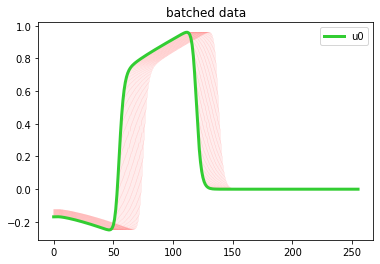

In [127]:
# Visual Check

# getting a batch
batch_u0, batch_u, batch_t, batch_p, s = get_batch()

# selecting i-th element of the batch
batch_element = 0

# taking the first time index of the batch element
i = s[batch_element]
print('parameter: ', batch_p[batch_element,:,:])

#plt.figure()
#plt.title('true u0')
#plt.plot(train_mat[i,:,:].cpu().flatten(),color='limegreen',label='true_u0')

plt.figure()
plt.title('batched data')

# Plotting the i-th element of the batch
for j in range(batch_time):
  plt.plot(batch_u[j,batch_element,:,:].cpu().flatten(),'--r',linewidth=.1)
plt.plot(batch_u0[batch_element,:,:].cpu().flatten(),color='limegreen',label='u0',linewidth=3)
plt.legend()

## Model Definition

In [86]:
class ConvODEFunc(nn.Module):
    def __init__(self):
        super(ConvODEFunc, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=16, kernel_size=(1,3), stride=1, padding='same'),
            nn.Tanh(),
            nn.Conv2d(in_channels=16, out_channels=1, kernel_size=(1,3), stride=1, padding='same')
        )
      
        self.conv[0].weight.data.normal_(0.0, 1/(16*3*2+16))
        self.conv[0].bias.data.fill_(.0)
        self.conv[2].weight.data.normal_(0.0, 1/(16*3+1))
        self.conv[2].bias.data.fill_(.0)
        
    def forward(self, t, y):
        
        o1 = self.conv(y)
        o2 = torch.zeros_like(o1)
        o = torch.cat((o1,o2),1)
        return o

In [87]:
func = ConvODEFunc().to(device) 

In [88]:
# here the ensemble is defined only to train multiple models at a time
ensemble = [ConvODEFunc().to(device) for i in range(ensemble_n)]

## Training

In [89]:
## *** IF NOT ENSEMBLE [only 1 odenet] ***#
if not train_ensemble:
    ii = 0
    lrate = 1e-3

    optimizer = optim.Adam(func.parameters(), lr=lrate)

    loss_array = []
    itr_time = []
    start = time.time()

    for itr in range(1, epochs + 1):

        start_itr = time.time()

        batch_u0, batch_u, batch_t, batch_p, s = get_batch()
        state_param_init=torch.stack((batch_u0,batch_p*torch.ones_like(batch_u0)),1)
        pred_u = odeint(func, state_param_init, batch_t,method=method).to(device)

        loss = torch.mean(torch.pow(pred_u[:,:,0,:,:] - batch_u,2))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        itr_time.append(time.time()-start_itr)
        loss_array.append(loss.item())

        if itr % test_freq == 0:
            with torch.no_grad():
                print('Iter ' + str(itr)+'/'+str(epochs) + '\t|  Loss: ' + str(round(loss.item(),6)) + '\t|  lr: ' + str(optimizer.param_groups[0]['lr']) + '\t|  itr time: ' +str(round(itr_time[-1],5)))
                #       visualize(true_u, pred_u, func, ii, batch_u0, batch_t)
                #       ii += 1

    total_elapsed_time = time.time()-start

Iter 50/1500	|  Loss: 0.010574	|  lr: 0.001	|  itr time: 0.08003
Iter 100/1500	|  Loss: 0.008974	|  lr: 0.001	|  itr time: 0.09467
Iter 150/1500	|  Loss: 0.011508	|  lr: 0.001	|  itr time: 0.11701
Iter 200/1500	|  Loss: 0.007927	|  lr: 0.001	|  itr time: 0.14175
Iter 250/1500	|  Loss: 0.007873	|  lr: 0.001	|  itr time: 0.15421
Iter 300/1500	|  Loss: 0.005837	|  lr: 0.001	|  itr time: 0.17997
Iter 350/1500	|  Loss: 0.005889	|  lr: 0.001	|  itr time: 0.20454
Iter 400/1500	|  Loss: 0.004613	|  lr: 0.001	|  itr time: 0.21698
Iter 450/1500	|  Loss: 0.005221	|  lr: 0.001	|  itr time: 0.21298
Iter 500/1500	|  Loss: 0.003532	|  lr: 0.001	|  itr time: 0.23894
Iter 550/1500	|  Loss: 0.004107	|  lr: 0.001	|  itr time: 0.21983
Iter 600/1500	|  Loss: 0.003147	|  lr: 0.001	|  itr time: 0.2222
Iter 650/1500	|  Loss: 0.003106	|  lr: 0.001	|  itr time: 0.22987
Iter 700/1500	|  Loss: 0.004025	|  lr: 0.001	|  itr time: 0.30962
Iter 750/1500	|  Loss: 0.004176	|  lr: 0.001	|  itr time: 0.21887
Iter 800/150

In [90]:
## *** IF TRAINING AN ENSEMBLE ***#
if train_ensemble:
    for jj,func in enumerate(ensemble):
        ii = 0
        lrate = 1e-3
        print('model #'+str(jj))

        optimizer = optim.Adam(func.parameters(), lr=lrate)

        loss_array = []
        itr_time = []
        start = time.time()

        for itr in range(1, epochs + 1):

            start_itr = time.time()

            batch_u0, batch_u, batch_t, batch_p, s = get_batch()
            state_param_init=torch.stack((batch_u0,batch_p*torch.ones_like(batch_u0)),1)
            pred_u = odeint(func, state_param_init, batch_t,method=method).to(device)

            loss = torch.mean(torch.pow(pred_u[:,:,0,:,:] - batch_u,2))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            itr_time.append(time.time()-start_itr)
            loss_array.append(loss.item())

            if itr % test_freq == 0:
                with torch.no_grad():
                    print('Iter ' + str(itr)+'/'+str(epochs) + '\t|  Loss: ' + str(round(loss.item(),6)) + '\t|  lr: ' + str(optimizer.param_groups[0]['lr']) + '\t|  itr time: ' +str(round(itr_time[-1],5)))
                    #       visualize(true_u, pred_u, func, ii, batch_u0, batch_t)
                    #       ii += 1

        total_elapsed_time = time.time()-start

# Testing
## Test on Training Data

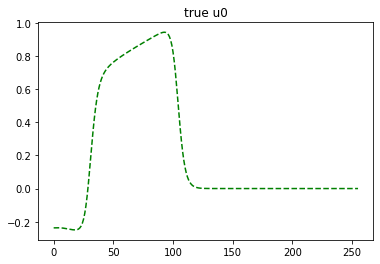

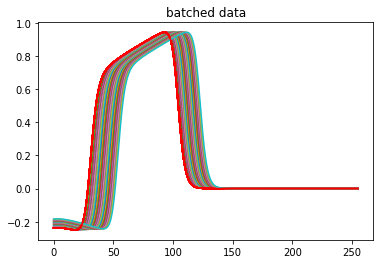

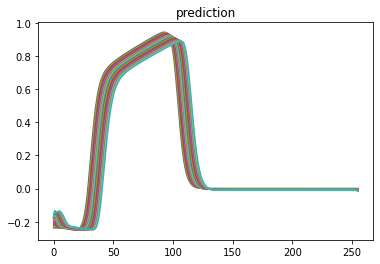

In [130]:
# Take a batch of data
batch_u0, batch_u, batch_t, batch_p, s = get_batch()
y0=torch.stack((batch_u0,batch_p*torch.ones_like(batch_u0)),1)

# Predict
pred_u = odeint(func, y0, batch_t,method=method).to(device)   


# Plot the prediction for batch_element
batch_element = 1
i = s[batch_element]
plt.figure()
plt.title('true u0')
plt.plot(train_mat[i,:,:].flatten(),'--g',label='true_u0')
plt.figure()
plt.title('batched data')
for j in range(batch_time):
  plt.plot(batch_u[j,batch_element,:,:].cpu().flatten())
  plt.plot(batch_u0[batch_element,:,:].cpu().flatten(),'-r',label='u0')
plt.savefig('target.png',dpi=200)

plt.figure()
plt.title('prediction')
for j in range(20):
  plt.plot(pred_u[j,batch_element,0,:,:].cpu().detach().flatten())

plt.savefig('pred.png',dpi=200)
#print(params_train_data[i])

## Time extrapolation

In [92]:
# odeint input
t0 = 400 - leave_out_for_time_test # t0 = 300
pred_t = torch.arange(400-t0).float().to(device)   
pred_u0 = train_mat[t0,:,:].unsqueeze(0).float().to(device)   
mu = params_mat[t0].to(device)*torch.ones_like(pred_u0)
u0 = torch.stack((pred_u0,mu),1)

pred_u = odeint(func, u0, pred_t,method=method).to(device)   

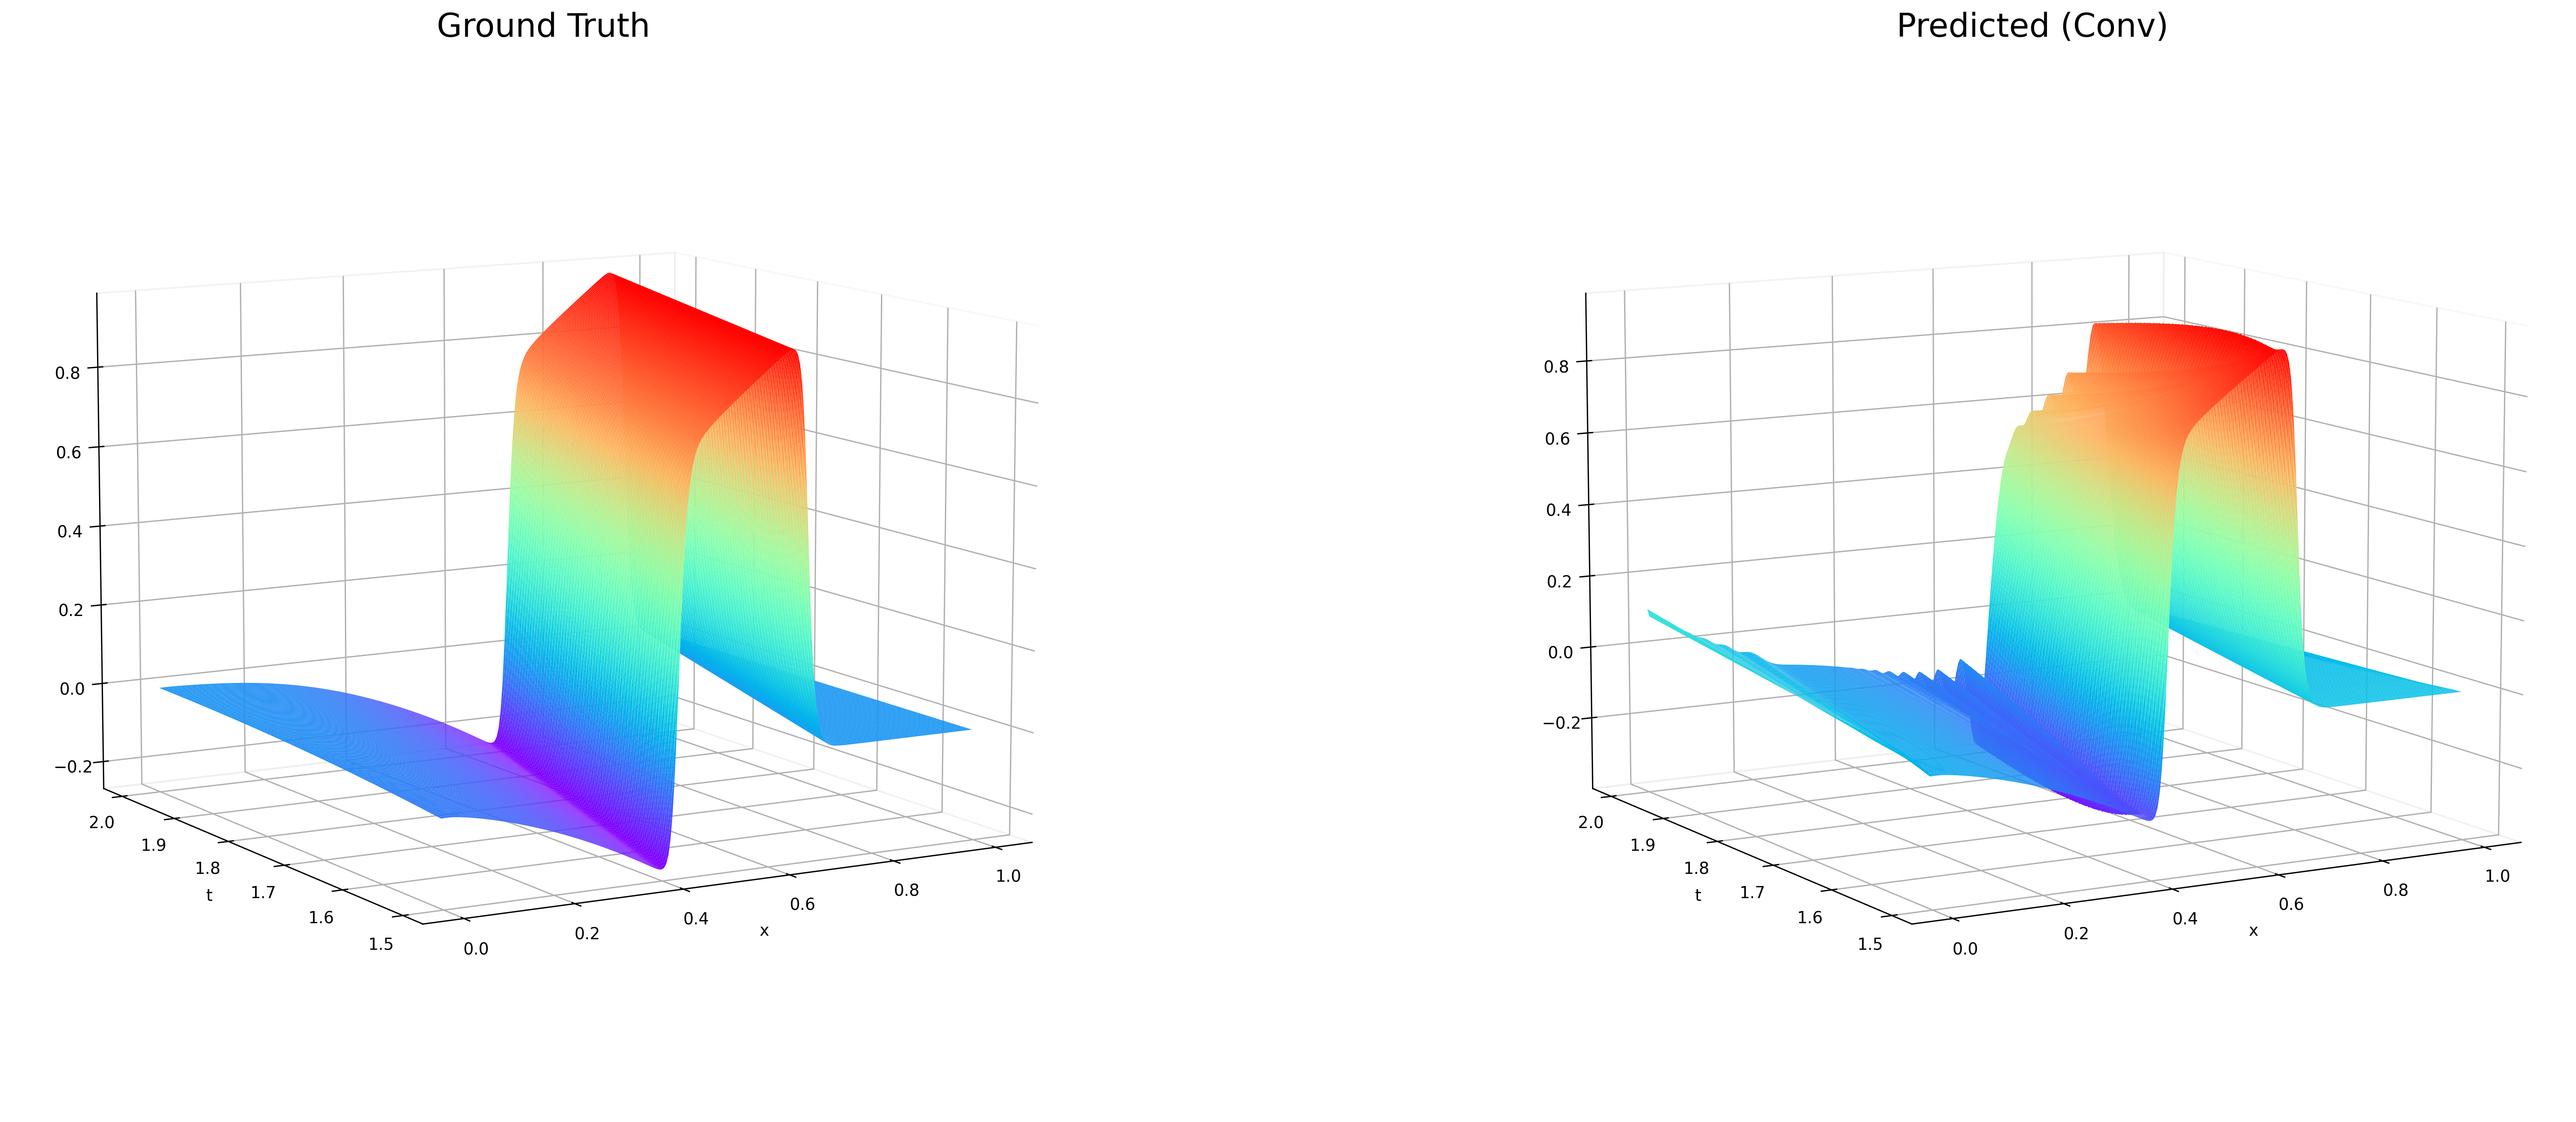

In [94]:
t = np.linspace(0, 2, 400)[t0:]
x = np.linspace(0, 1, 256)

X, Y = np.meshgrid(x, t)
Z_2 = train_mat[t0:400,:].squeeze(1).numpy()
fig = plt.figure(figsize=(30,12),dpi=300)
ax = fig.add_subplot(121,projection='3d')
ax.plot_surface(X, Y, Z_2, cmap=plt.cm.rainbow,linewidth=0, antialiased=True,rcount=1000, ccount=1000)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.set_title('Ground Truth',fontsize=20)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.view_init(10, 240)


X, Y = np.meshgrid(x, t)
Z_1 = pred_u[:,0,0,0,:].detach().cpu().numpy()
ax = fig.add_subplot(122,projection='3d')
ax.plot_surface(X, Y, Z_1, cmap=plt.cm.rainbow,linewidth=0, antialiased=True,rcount=1000, ccount=1000)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.set_xlabel('x')
ax.set_ylabel('t')

ax.set_title('Predicted (Conv)',fontsize=20)
ax.view_init(10, 240)
plt.savefig('denseconv.png',dpi=300,bbox_inches='tight',transparent=False)

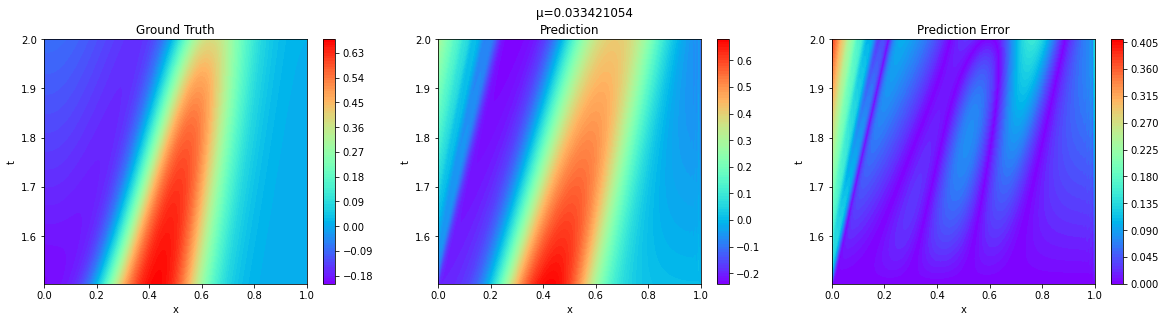

In [137]:
#func = ensemble[2]

t0 = 300
block = 12 # the parameter can be chosen by selecting the block [0,...,19] on which the test has to be performed
block_start_idx = 400*block
pred_t = torch.arange(400-t0).float().to(device)   
pred_u0 = train_mat[block_start_idx+t0,:,:].unsqueeze(0).float().to(device)   
mu = params_mat[block_start_idx+t0].to(device)*torch.ones_like(pred_u0)
u0 = torch.stack((pred_u0,mu),1)
pred_u = odeint(func, u0, pred_t,method=method).to(device)   

t = np.linspace(0, 2, 400)[t0:]
x = np.linspace(0, 1, 256)

X, Y = np.meshgrid(x, t)
Z_2 = train_mat[block_start_idx+t0:block_start_idx+400,:].squeeze(1).numpy()
fig = plt.figure(figsize=(20,4.5))
ax1 = fig.add_subplot(131)
plt1 = ax1.contourf(X, Y, Z_2,100,cmap=plt.cm.rainbow)
ax1.set_title('Ground Truth')
ax1.set_xlabel('x')
ax1.set_ylabel('t')

ax2 = fig.add_subplot(132)
Z_1 = pred_u[:,0,0,0,:].detach().cpu().numpy()
plt2 = ax2.contourf(X, Y, Z_1,100,cmap=plt.cm.rainbow)
ax2.set_xlabel('x')
ax2.set_ylabel('t')
ax2.set_title('Prediction')

ax3 = fig.add_subplot(133)
ax3.set_title('Prediction Error')
plt3 = ax3.contourf(X, Y, np.abs(Z_2-Z_1),100,cmap=plt.cm.rainbow)
ax3.set_xlabel('x')
ax3.set_ylabel('t')

fig.colorbar(plt1, ax=ax1)
fig.colorbar(plt2, ax=ax2)
fig.colorbar(plt3, ax=ax3)
plt.suptitle('μ='+str(mu[0,0,0].cpu().numpy()))
plt.savefig('pde1.png',dpi=300,bbox_inches='tight',transparent=False)

## Out-of-Parameters Space Test

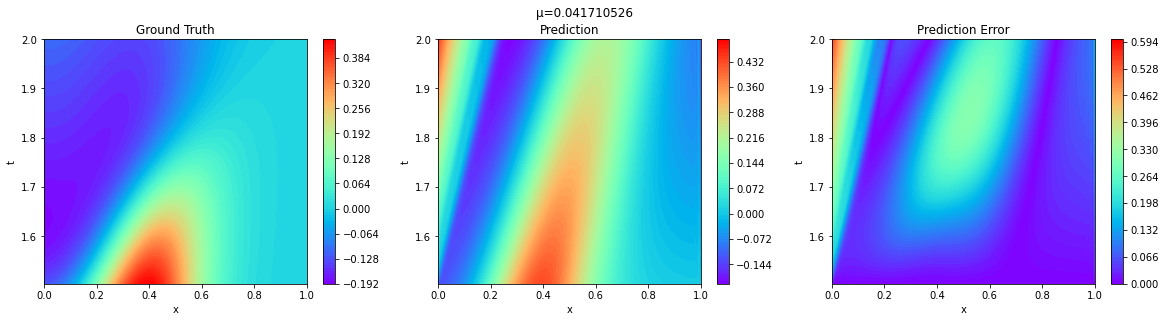

In [141]:
#func = ensemble[2]

t0 = 300
block = 15 # the parameter can be chosen by selecting the block [0,...,18] on which the test has to be performed
block_start_idx = 400*block
pred_t = torch.arange(400-t0).float().to(device)   
pred_u0 = test_mat[block_start_idx+t0,:,:].unsqueeze(0).float().to(device)   
mu = params_mat_test[block_start_idx+t0].float().to(device)*torch.ones_like(pred_u0)
u0 = torch.stack((pred_u0,mu),1)
pred_u = odeint(func, u0, pred_t,method=method).to(device)   

t = np.linspace(0, 2, 400)[t0:]
x = np.linspace(0, 1, 256)

X, Y = np.meshgrid(x, t)
Z_2 = test_mat[block_start_idx+t0:block_start_idx+400,:].squeeze(1).numpy()
fig = plt.figure(figsize=(20,4.5))
ax1 = fig.add_subplot(131)
plt1 = ax1.contourf(X, Y, Z_2,100,cmap=plt.cm.rainbow)
ax1.set_title('Ground Truth')
ax1.set_xlabel('x')
ax1.set_ylabel('t')

ax2 = fig.add_subplot(132)
Z_1 = pred_u[:,0,0,0,:].detach().cpu().numpy()
plt2 = ax2.contourf(X, Y, Z_1,100,cmap=plt.cm.rainbow)
ax2.set_xlabel('x')
ax2.set_ylabel('t')
ax2.set_title('Prediction')

ax3 = fig.add_subplot(133)
ax3.set_title('Prediction Error')
plt3 = ax3.contourf(X, Y, np.abs(Z_2-Z_1),100,cmap=plt.cm.rainbow)
ax3.set_xlabel('x')
ax3.set_ylabel('t')

fig.colorbar(plt1, ax=ax1)
fig.colorbar(plt2, ax=ax2)
fig.colorbar(plt3, ax=ax3)
plt.suptitle('μ='+str(mu[0,0,0].cpu().numpy()))
plt.savefig('pde1.png',dpi=300,bbox_inches='tight',transparent=False)

In [116]:
def save_ensemble(ensemble):
    for i,model in enumerate(ensemble):
        torch.save(model,'ef'+str(i)+'.pt')

In [118]:
if train_ensemble:
    save_ensemble(ensemble)
else:
    torch.save(func,'odenet.pt')